In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [ ]:
# let's begin putting together the transcriptome simulation set

# What we need
# number of transcripts to simulate (what is an average number of transcripts per tissue?)
# number of loci (average for a tissue)
# for each locus need to draw the number of transcripts of each category, such that the final distributions
#     are close to tissue averages

# then for each transcript need to draw from the distribution of total contribution to expression
#     such that the final distributions resemble those observed in real data

In [25]:
# declarations
base_dir = "/home/sparrow/JHU/gtex_stats/"
out_dir = "/home/sparrow/JHU/tx_noise/"
hg38_fa = "/home/sparrow/genomicData/hg38/hg38_p8.fa"

genRNAseq = "/home/sparrow/genomicTools/genRNAseq_noFold_cov.R"

readlen = 101

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [26]:
# load base annotations
real_baseDF = pd.read_csv(base_dir+"data/ALL.combined.IDs.olny.in.ALL.combined.true.gtf",sep="\t",names=gff3cols)
real_baseDF = real_baseDF[real_baseDF["type"]=="transcript"].reset_index(drop=True)
nonint_baseDF = pd.read_csv(base_dir+"data/ALL.combined.IDs.olny.in.ALL.combined.no.contained.non.intronic.gtf",sep="\t",names=gff3cols)
nonint_baseDF = nonint_baseDF[nonint_baseDF["type"]=="transcript"].reset_index(drop=True)
int_baseDF = pd.read_csv(base_dir+"data/ALL.combined.IDs.olny.in.ALL.combined.no.contained.intronic.gtf",sep="\t",names=gff3cols)
int_baseDF = int_baseDF[int_baseDF["type"]=="transcript"].reset_index(drop=True)
pol_baseDF = pd.read_csv(base_dir+"data/ALL.combined.IDs.olny.in.ALL.combined.no.contained.RNApol.gtf",sep="\t",names=gff3cols)
pol_baseDF = pol_baseDF[pol_baseDF["type"]=="transcript"].reset_index(drop=True)

In [27]:
# get all loci and transcript IDs
real_baseDF["lid"] = real_baseDF["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
nonint_baseDF["lid"] = nonint_baseDF["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
int_baseDF["lid"] = int_baseDF["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
pol_baseDF["lid"] = pol_baseDF["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
real_locs = set(real_baseDF["lid"])
nonint_locs = set(nonint_baseDF["lid"])
int_locs = set(int_baseDF["lid"])
pol_locs = set(pol_baseDF["lid"])
print(len(real_locs),len(nonint_locs),len(int_locs),len(pol_locs))
real_baseDF.head()

16878 10479 10981 26851


,seqid,source,type,start,end,score,strand,phase,attributes,lid
0,chr1,StringTie,transcript,69091,70008,.,+,.,"transcript_id ""ALL_00000003""; gene_id ""XLOC_00...",XLOC_000002
1,chr1,StringTie,transcript,629081,629452,.,+,.,"transcript_id ""ALL_00000006""; gene_id ""XLOC_00...",XLOC_000005
2,chr1,StringTie,transcript,629503,630651,.,+,.,"transcript_id ""ALL_00000008""; gene_id ""XLOC_00...",XLOC_000005
3,chr1,StringTie,transcript,778760,810065,.,+,.,"transcript_id ""ALL_00028685""; gene_id ""XLOC_00...",XLOC_000007
4,chr1,StringTie,transcript,817371,819834,.,+,.,"transcript_id ""ALL_00000055""; gene_id ""XLOC_00...",XLOC_000008


In [28]:
# perform cleanup, by removing any loci in 
#   1. int that are also in real
#   2. nonint that are not in real
#   3. pol that are in real
int_locs = int_locs - real_locs.intersection(int_locs)
assert(len(real_locs.intersection(int_locs))==0),"something wrong intronic"
int_baseDF = int_baseDF[int_baseDF["lid"].isin(int_locs)].reset_index(drop=True)

nonint_locs = nonint_locs - nonint_locs.difference(real_locs)
assert(len(nonint_locs) == len(real_locs.intersection(nonint_locs))),"something wrong non-intronic"
nonint_baseDF = nonint_baseDF[nonint_baseDF["lid"].isin(nonint_locs)].reset_index(drop=True)

pol_locs = pol_locs - real_locs.intersection(pol_locs)
assert(len(real_locs.intersection(pol_locs))==0),"something wrong polymerase"
pol_baseDF = pol_baseDF[pol_baseDF["lid"].isin(pol_locs)].reset_index(drop=True)

print(len(real_locs),len(nonint_locs),len(int_locs),len(pol_locs))

16878 10458 9689 25174


In [29]:
real_baseDF["tid"] = real_baseDF["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
real_baseDF = real_baseDF[["lid","tid"]]
nonint_baseDF["tid"] = nonint_baseDF["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
nonint_baseDF = nonint_baseDF[["lid","tid"]]
int_baseDF["tid"] = int_baseDF["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
int_baseDF = int_baseDF[["lid","tid"]]
pol_baseDF["tid"] = pol_baseDF["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
pol_baseDF = pol_baseDF[["lid","tid"]]

In [30]:
avg_real_locs = 0
avg_noise_locs = 0
avg_undefined_locs = 0
with open(base_dir+"out_test/res_distrib.loc_stats","r") as inFP:
    for line in inFP.readlines():
        type_loc,num_loc = line.split(":")
        if type_loc=="real":
            avg_real_locs = int(num_loc)
        elif type_loc=="noise":
            avg_noise_locs = int(num_loc)
        elif type_loc=="undefined":
            if(int(num_loc))>0:
                avg_undefined_locs = int(num_loc)
        else:
            print("error in loading averages")
print("average real locs: "+str(avg_real_locs))
print("average noise locs: "+str(avg_noise_locs))
print("average undefined locs: "+str(avg_undefined_locs))

average real locs: 16350
average noise locs: 21322
average undefined locs: 19369


In [31]:
# randomly select loci of each type based on the averages
# noise loci are a combination of: intronic and polymerase
# this needs to be done proportionally to the consistent parts of each group (real(real,nonint) and noise(int,pol))

real_only_locs = real_locs - nonint_locs

# in case of inconsistencies associated with merging transcripts of different types under the same locus
# we need to scale the averages with respect to the new numbers
avg_total_locs = avg_real_locs+avg_noise_locs
# now scale these averages such that
# new_avg_real_locs <= len(real_only_locs and nonint_locs)
# new_avg_noise_locs <= len(int_locs and pol_locs)
sum_locs_to_choose_from = len(real_only_locs)+len(nonint_locs)+len(int_locs)+len(pol_locs)
# new_avg_real_locs = int((len(nonint_locs)+len(real_only_locs))*(avg_real_locs/avg_total_locs))
# new_avg_noise_locs = int((len(pol_locs)+len(int_locs))*(avg_noise_locs/avg_total_locs))

print("old avg real locs: "+str(avg_real_locs))
# print("new avg real locs: "+str(new_avg_real_locs))
print("old avg noise locs: "+str(avg_noise_locs))
# print("new avg noise locs: "+str(new_avg_noise_locs))

print("real locs: "+str(len(real_only_locs)))
print("nonint locs: "+str(len(nonint_locs)))
print("int locs: "+str(len(int_locs)))
print("pol locs: "+str(len(pol_locs)))

perc_real = len(real_only_locs)/len(real_locs)
perc_nonint = len(nonint_locs)/len(real_locs)
assert(perc_real+perc_nonint)==1,"wrong percent real and nonint"

perc_int = len(int_locs)/(len(int_locs)+len(pol_locs))
perc_pol = len(pol_locs)/(len(int_locs)+len(pol_locs))
assert((perc_int+perc_pol)==1),"wrong percent pol and int"
print("selecting n real locs: "+str(int(avg_real_locs*perc_real)))
print("selecting n nonint locs: "+str(int(avg_real_locs*perc_nonint)))
print("selecting n int locs: "+str(int(avg_noise_locs*perc_int)))
print("selecting n pol locs: "+str(int(avg_noise_locs*perc_pol)))

real_only_locs_rand = np.random.choice(list(real_only_locs),int(avg_real_locs*perc_real), replace=False)
nonint_locs_rand = np.random.choice(list(nonint_locs),int(avg_real_locs*perc_nonint), replace=False)
int_locs_rand = np.random.choice(list(int_locs),int(avg_noise_locs*perc_int), replace=False)
pol_locs_rand = np.random.choice(list(pol_locs),int(avg_noise_locs*perc_pol), replace=False)

old avg real locs: 16350
old avg noise locs: 21322
real locs: 6420
nonint locs: 10458
int locs: 9689
pol locs: 25174
selecting n real locs: 6219
selecting n nonint locs: 10130
selecting n int locs: 5925
selecting n pol locs: 15396


In [32]:
real_only_baseDF = real_baseDF[real_baseDF["lid"].isin(real_only_locs_rand)].reset_index(drop=True)
real_nonint_baseDF = real_baseDF[(real_baseDF["lid"].isin(nonint_locs_rand))&~(real_baseDF["lid"].isin(real_only_locs_rand))].reset_index(drop=True)
nonint_baseDF = nonint_baseDF[nonint_baseDF["lid"].isin(nonint_locs_rand)].reset_index(drop=True)
int_baseDF = int_baseDF[int_baseDF["lid"].isin(int_locs_rand)].reset_index(drop=True)
pol_baseDF = pol_baseDF[pol_baseDF["lid"].isin(pol_locs_rand)].reset_index(drop=True)
print(len(set(real_only_baseDF["lid"])),len(set(real_nonint_baseDF["lid"])),len(set(nonint_baseDF["lid"])),len(set(pol_baseDF["lid"])))
print(len(set(real_only_baseDF["tid"])),len(set(real_nonint_baseDF["tid"])),len(set(nonint_baseDF["tid"])),len(set(pol_baseDF["tid"])))

6219 10130 10130 15396
11569 26813 105843 36937


/home/sparrow/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


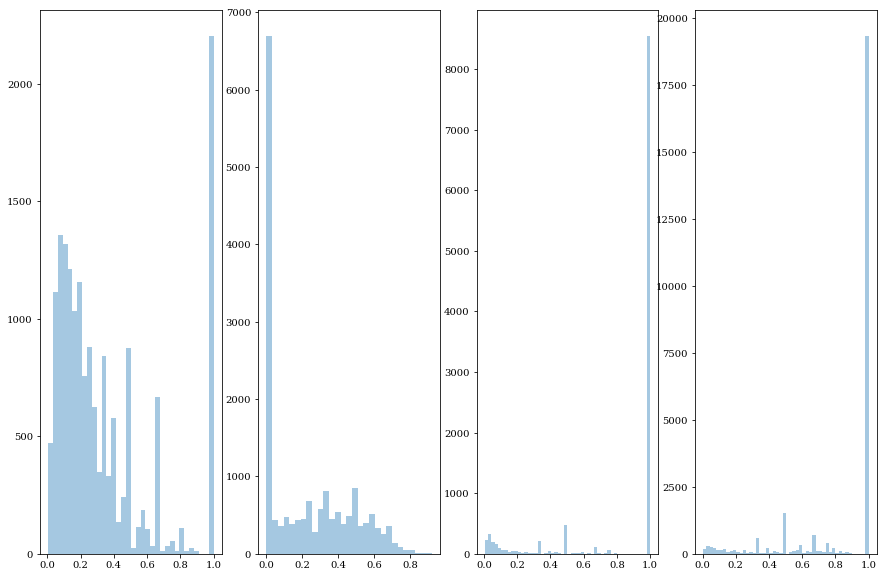

<Figure size 1080x720 with 0 Axes>

In [33]:
# load the transcript tissue distribution
ttx_real = list()
ttx_nonint = list()
ttx_int = list()
ttx_pol = list()

tmp_tx = pd.read_csv(base_dir+"out_test/res_distrib.num_tx_per_tissue_loc2")
tmp_tx_real_loc = tmp_tx[(tmp_tx["real"]>0)][["total","real","nonintronic"]].reset_index(drop=True)
tmp_tx_real_loc["perc_real"] = tmp_tx_real_loc["real"]/tmp_tx_real_loc["total"]
tmp_tx_real_loc["perc_nonint"] = tmp_tx_real_loc["nonintronic"]/tmp_tx_real_loc["total"]
d_real = list(tmp_tx_real_loc["perc_real"])
d_nonint = list(tmp_tx_real_loc["perc_nonint"])

tmp_tx_int_loc = tmp_tx[(tmp_tx["intronic"]>0)][["total","intronic"]].reset_index(drop=True)
tmp_tx_int_loc["perc_int"] = tmp_tx_int_loc["intronic"]/tmp_tx_int_loc["total"]
d_int = list(tmp_tx_int_loc["perc_int"])

tmp_tx_pol_loc = tmp_tx[(tmp_tx["polymerase"]>0)][["total","polymerase"]].reset_index(drop=True)
tmp_tx_pol_loc["perc_pol"] = tmp_tx_pol_loc["polymerase"]/tmp_tx_pol_loc["total"]
d_pol = list(tmp_tx_pol_loc["perc_pol"])

plt.rcParams['figure.figsize'] = (15.0, 10.0)
fig, ax =plt.subplots(1,4)
plt.figure()
sns.distplot(d_real,kde=False,ax=ax[0]);
sns.distplot(d_nonint,kde=False,ax=ax[1]);
sns.distplot(d_int,kde=False,ax=ax[2]);
sns.distplot(d_pol,kde=False,ax=ax[3]);
fig.show()

In [35]:
# now that we have the loci, we can subset the gtfs and move on to working with the transcripts
# the question is: how do we allocate transcripts per locus?
# do we do this based on the distribution of the number of transcripts per each type of locus?
# are there any caveates in the co-dependencies such as between real and non-intronic?

# we should probably only select transcripts of each group within each type of locus dataframe

# one important consideration is that the total number of transcripts should be close to what is observed
#  in an average tissue (needs to be computed in the gtex_stats)
# this approach, however, might be overly complicated, and simply randomly selecting n transcripts for each group
#  based on distribution computed by gtex_stats might be sufficient, and should approximate well to desired values

real_only_txs = set()
for name, group in real_only_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    nt = math.ceil(d_real[random.randint(0,len(d_real)-1)]*len(tids))
    random.shuffle(tids)
    real_only_txs.update(tids[:nt])

# what we need here is a real_baseDF which contains the loci from the nonint_baseDF
real_nonint_txs = set()
for name, group in real_nonint_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    nt = math.ceil(d_real[random.randint(0,len(d_real)-1)]*len(tids))
    random.shuffle(tids)
    real_nonint_txs.update(tids[:nt])
    
nonint_txs = set()
for name, group in nonint_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    nt = math.ceil(d_nonint[random.randint(0,len(d_nonint)-1)]*len(tids))
    random.shuffle(tids)
    nonint_txs.update(tids[:nt])
    
int_txs = set()
for name, group in int_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    nt = math.ceil(d_int[random.randint(0,len(d_int)-1)]*len(tids))
    random.shuffle(tids)
    int_txs.update(tids[:nt])
    
pol_txs = set()
for name, group in pol_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    nt = math.ceil(d_pol[random.randint(0,len(d_pol)-1)]*len(tids))
    random.shuffle(tids)
    pol_txs.update(tids[:nt])

# now do the same to the nonint,int,pol
print(len(real_only_txs),len(real_nonint_txs),len(nonint_txs),len(int_txs),len(pol_txs))

7592 14770 26661 8029 33364


In [36]:
# now that we have lists of transcripts - we can subset the annotation further
print(len(real_only_baseDF))
real_only_baseDF = real_only_baseDF[real_only_baseDF["tid"].isin(real_only_txs)].reset_index(drop=True)
print(len(real_only_baseDF))
print(len(real_nonint_baseDF))
real_nonint_baseDF = real_nonint_baseDF[real_nonint_baseDF["tid"].isin(real_nonint_txs)].reset_index(drop=True)
print(len(real_nonint_baseDF))
print(len(nonint_baseDF))
nonint_baseDF = nonint_baseDF[nonint_baseDF["tid"].isin(nonint_txs)].reset_index(drop=True)
print(len(nonint_baseDF))
print(len(int_baseDF))
int_baseDF = int_baseDF[int_baseDF["tid"].isin(int_txs)].reset_index(drop=True)
print(len(int_baseDF))
print(len(pol_baseDF))
pol_baseDF = pol_baseDF[pol_baseDF["tid"].isin(pol_txs)].reset_index(drop=True)
print(len(pol_baseDF))

11569
7592
26813
14770
105843
26661
8546
8029
36937
33364


/home/sparrow/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


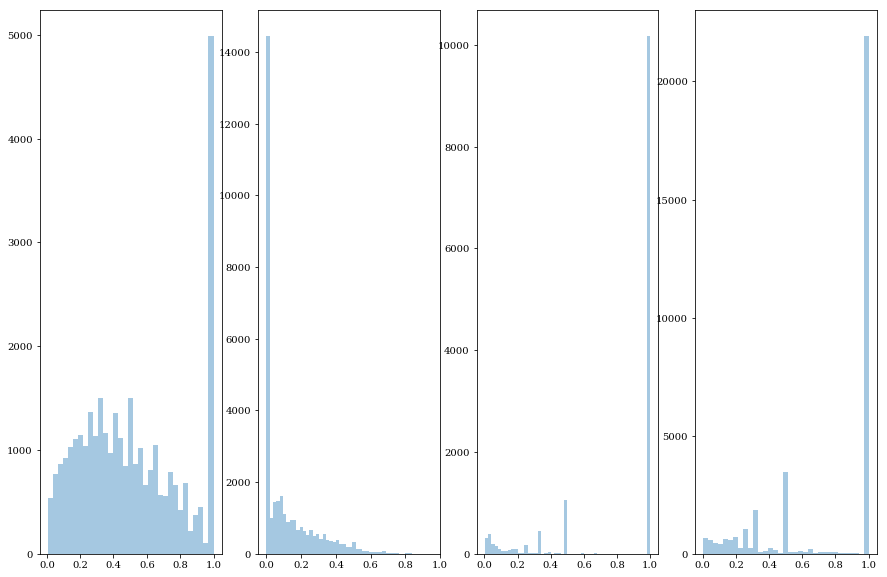

<Figure size 1080x720 with 0 Axes>

In [38]:
# lastly we need to generate samples based on the underlying annotation
# for this we will need additional information, similar to the tissue_per_loc2 in order to tell
# how likely a sample is to contribute a transcript to a tissue

# load the transcript sample distribution
ttx_real = list()
ttx_nonint = list()
ttx_int = list()
ttx_pol = list()

tmp_tx = pd.read_csv(base_dir+"out_test/res_distrib.num_tx_per_sample_loc2")
tmp_tx_real_loc = tmp_tx[(tmp_tx["real"]>0)][["total","real","nonintronic"]].reset_index(drop=True)
tmp_tx_real_loc["perc_real"] = tmp_tx_real_loc["real"]/tmp_tx_real_loc["total"]
tmp_tx_real_loc["perc_nonint"] = tmp_tx_real_loc["nonintronic"]/tmp_tx_real_loc["total"]
d_real = list(tmp_tx_real_loc["perc_real"])
d_nonint = list(tmp_tx_real_loc["perc_nonint"])

tmp_tx_int_loc = tmp_tx[(tmp_tx["intronic"]>0)][["total","intronic"]].reset_index(drop=True)
tmp_tx_int_loc["perc_int"] = tmp_tx_int_loc["intronic"]/tmp_tx_int_loc["total"]
d_int = list(tmp_tx_int_loc["perc_int"])

tmp_tx_pol_loc = tmp_tx[(tmp_tx["polymerase"]>0)][["total","polymerase"]].reset_index(drop=True)
tmp_tx_pol_loc["perc_pol"] = tmp_tx_pol_loc["polymerase"]/tmp_tx_pol_loc["total"]
d_pol = list(tmp_tx_pol_loc["perc_pol"])

plt.rcParams['figure.figsize'] = (15.0, 10.0)
fig, ax =plt.subplots(1,4)
plt.figure()
sns.distplot(d_real,kde=False,ax=ax[0]);
sns.distplot(d_nonint,kde=False,ax=ax[1]);
sns.distplot(d_int,kde=False,ax=ax[2]);
sns.distplot(d_pol,kde=False,ax=ax[3]);
fig.show()

In [39]:
num_samples = 10 # number of samples to simulate

real_only_txs = [set() for x in range(num_samples)]
for name, group in real_only_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    for i in range(num_samples):
        nt = math.ceil(d_real[random.randint(0,len(d_real)-1)]*len(tids))
        random.shuffle(tids)
        real_only_txs[i].update(tids[:nt])
        
real_nonint_txs = [set() for x in range(num_samples)]
for name, group in real_nonint_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    for i in range(num_samples):
        nt = math.ceil(d_real[random.randint(0,len(d_real)-1)]*len(tids))
        random.shuffle(tids)
        real_nonint_txs[i].update(tids[:nt])

nonint_txs = [set() for x in range(num_samples)]
for name, group in nonint_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    for i in range(num_samples):
        nt = math.ceil(d_nonint[random.randint(0,len(d_nonint)-1)]*len(tids))
        random.shuffle(tids)
        nonint_txs[i].update(tids[:nt])      

int_txs = [set() for x in range(num_samples)]
for name, group in int_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    for i in range(num_samples):
        nt = math.ceil(d_int[random.randint(0,len(d_int)-1)]*len(tids))
        random.shuffle(tids)
        int_txs[i].update(tids[:nt])
        
pol_txs = [set() for x in range(num_samples)]
for name, group in pol_baseDF.groupby("lid"):
    tids = group["tid"].tolist()
    for i in range(num_samples):
        nt = math.ceil(d_pol[random.randint(0,len(d_pol)-1)]*len(tids))
        random.shuffle(tids)
        pol_txs[i].update(tids[:nt])

In [40]:
# now that we have sample specific stuff - we can generate sample-specific GTFs
real_baseDF = pd.read_csv(base_dir+"data/ALL.combined.IDs.olny.in.ALL.combined.true.gtf",sep="\t",names=gff3cols)
nonint_baseDF = pd.read_csv(base_dir+"data/ALL.combined.IDs.olny.in.ALL.combined.no.contained.non.intronic.gtf",sep="\t",names=gff3cols)
int_baseDF = pd.read_csv(base_dir+"data/ALL.combined.IDs.olny.in.ALL.combined.no.contained.intronic.gtf",sep="\t",names=gff3cols)
pol_baseDF = pd.read_csv(base_dir+"data/ALL.combined.IDs.olny.in.ALL.combined.no.contained.RNApol.gtf",sep="\t",names=gff3cols)
real_baseDF["tid"] = real_baseDF["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
nonint_baseDF["tid"] = nonint_baseDF["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
int_baseDF["tid"] = int_baseDF["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
pol_baseDF["tid"] = pol_baseDF["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]

for i in range(num_samples):
    real_baseDF[real_baseDF["tid"].isin(real_only_txs[i].union(real_nonint_txs[i]))][gff3cols].to_csv(out_dir+"/res.real.sample"+str(i)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
    nonint_baseDF[nonint_baseDF["tid"].isin(nonint_txs[i])][gff3cols].to_csv(out_dir+"/res.nonint.sample"+str(i)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
    int_baseDF[int_baseDF["tid"].isin(int_txs[i])][gff3cols].to_csv(out_dir+"/res.int.sample"+str(i)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
    pol_baseDF[pol_baseDF["tid"].isin(pol_txs[i])][gff3cols].to_csv(out_dir+"/res.pol.sample"+str(i)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)

1.0 75334.2


/home/sparrow/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


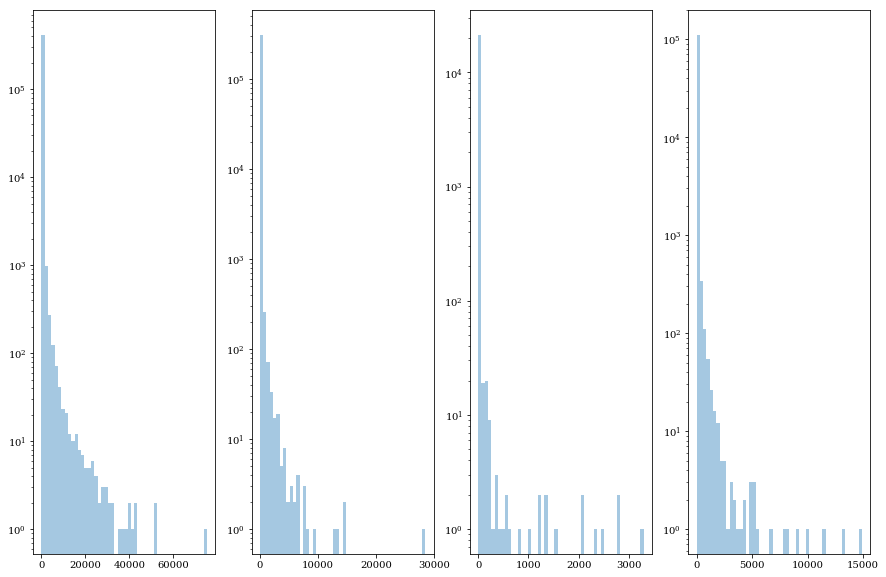

<Figure size 1080x720 with 0 Axes>

In [62]:
# load distribution of the sum of expressions
tmp_exp_real = pd.read_csv(base_dir+"out_test/res.cov_sample_real")
d_exp_real = list(tmp_exp_real[tmp_exp_real["cov"]>=1]["cov"])

tmp_exp_nonint = pd.read_csv(base_dir+"out_test/res.cov_sample_nonintronic")
d_exp_nonint = list(tmp_exp_nonint[tmp_exp_nonint["cov"]>=1]["cov"])

tmp_exp_int = pd.read_csv(base_dir+"out_test/res.cov_sample_intronic")
d_exp_int = list(tmp_exp_int[tmp_exp_int["cov"]>=1]["cov"])

tmp_exp_pol = pd.read_csv(base_dir+"out_test/res.cov_sample_polymerase")
d_exp_pol = list(tmp_exp_pol[tmp_exp_pol["cov"]>=1]["cov"])

print(min(d_exp_real),max(d_exp_real))

plt.rcParams['figure.figsize'] = (15.0, 10.0)
fig, ax =plt.subplots(1,4)
plt.figure()
sns.distplot(d_exp_real,kde=False,ax=ax[0]);
sns.distplot(d_exp_nonint,kde=False,ax=ax[1]);
sns.distplot(d_exp_int,kde=False,ax=ax[2]);
sns.distplot(d_exp_pol,kde=False,ax=ax[3]);
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[3].set_yscale("log")
fig.show()

In [63]:
# now generate corresponding expression matrices for the transcripts in each sample for each type
for i in range(num_samples):
    realDF = pd.read_csv(out_dir+"/res.real.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
    nt_real = len(realDF[realDF["type"]=="transcript"])
    exps_real = np.random.choice(d_exp_real, nt_real, replace=False)
    np.savetxt(out_dir+"/res.real.sample"+str(i)+".exp", exps_real, delimiter=',',fmt='%0.2f')
    
    nonintDF = pd.read_csv(out_dir+"/res.nonint.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
    nt_nonint = len(nonintDF[nonintDF["type"]=="transcript"])
    exps_nonint = np.random.choice(d_exp_nonint, nt_nonint, replace=False)
    np.savetxt(out_dir+"/res.nonint.sample"+str(i)+".exp", exps_nonint, delimiter=',',fmt='%0.2f')
    
    intDF = pd.read_csv(out_dir+"/res.int.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
    nt_int = len(intDF[intDF["type"]=="transcript"])
    exps_int = np.random.choice(d_exp_int, nt_int, replace=False)
    np.savetxt(out_dir+"/res.int.sample"+str(i)+".exp", exps_int, delimiter=',',fmt='%0.2f')
    
    polDF = pd.read_csv(out_dir+"/res.pol.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
    nt_pol = len(polDF[polDF["type"]=="transcript"])
    exps_pol = np.random.choice(d_exp_pol, nt_pol, replace=False)
    np.savetxt(out_dir+"/res.pol.sample"+str(i)+".exp", exps_pol, delimiter=',',fmt='%0.2f')

In [50]:
# generate transcriptomes for each file with gffread
for i in range(num_samples):
    cmd_real = ["gffread",
                "-w",out_dir+"res.real.sample"+str(i)+".fasta",
                "-g",hg38_fa,
                out_dir+"res.real.sample"+str(i)+".gtf"]
    subprocess.call(cmd_real)
    
    cmd_nonint = ["gffread",
                "-w",out_dir+"res.nonint.sample"+str(i)+".fasta",
                "-g",hg38_fa,
                out_dir+"res.nonint.sample"+str(i)+".gtf"]
    subprocess.call(cmd_nonint)
    
    cmd_int = ["gffread",
                "-w",out_dir+"res.int.sample"+str(i)+".fasta",
                "-g",hg38_fa,
                out_dir+"res.int.sample"+str(i)+".gtf"]
    subprocess.call(cmd_int)
    
    cmd_pol = ["gffread",
                "-w",out_dir+"res.pol.sample"+str(i)+".fasta",
                "-g",hg38_fa,
                out_dir+"res.pol.sample"+str(i)+".gtf"]
    subprocess.call(cmd_pol)

In [67]:
for i in range(num_samples):
    print(i)
    if not os.path.exists(out_dir+"res.real.sample"+str(i)):
        os.makedirs(out_dir+"res.real.sample"+str(i))
    cmd_real = [genRNAseq,
                out_dir+"res.real.sample"+str(i)+".fasta",
                out_dir+"res.real.sample"+str(i)+".exp",
                str(readlen),
                out_dir+"res.real.sample"+str(i)+"/"]
    subprocess.call(cmd_real)
    
    if not os.path.exists(out_dir+"res.nonint.sample"+str(i)):
        os.makedirs(out_dir+"res.nonint.sample"+str(i))
    cmd_nonint = [genRNAseq,
                out_dir+"res.nonint.sample"+str(i)+".fasta",
                out_dir+"res.nonint.sample"+str(i)+".exp",
                str(readlen),
                out_dir+"res.nonint.sample"+str(i)+"/"]
    subprocess.call(cmd_nonint)
    
    if not os.path.exists(out_dir+"res.int.sample"+str(i)):
        os.makedirs(out_dir+"res.int.sample"+str(i))
    cmd_int = [genRNAseq,
                out_dir+"res.int.sample"+str(i)+".fasta",
                out_dir+"res.int.sample"+str(i)+".exp",
                str(readlen),
                out_dir+"res.int.sample"+str(i)+"/"]
    subprocess.call(cmd_int)
    
    if not os.path.exists(out_dir+"res.pol.sample"+str(i)):
        os.makedirs(out_dir+"res.pol.sample"+str(i))
    cmd_pol = [genRNAseq,
                out_dir+"res.pol.sample"+str(i)+".fasta",
                out_dir+"res.pol.sample"+str(i)+".exp",
                str(readlen),
                out_dir+"res.pol.sample"+str(i)+"/"]
    subprocess.call(cmd_pol)

0
1
2
3
4
5
6
7
8
9


In [ ]:
# before we build an index we also need a consolidated database that contains all real transcripts in it
# so it can be used for salmon, kallisto and hisat2 with stringtie2

In [ ]:
# now to build salmon and hisat2 indices


In [ ]:
# then run the alignment

In [ ]:
# now that the gtfs are created, we need to setup expression matrices to be used by polyester to get reads

# for number of reads estimate we can rely on the contribution to expression estimate, defined in the computed
#   distribution.
# for each transcript in each sample get a matrix in the polyester format to simultae reads from


# run hisat2+stringtie2,salmon,kallisto